<a href="https://colab.research.google.com/github/carlibeisel/CDL_analyze_croptype_by_pixel/blob/main/*irrigation_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Identifying Pivot Irrigated Land for Drains

By: Carli Beisel

Adapted from David Ketchum (Github: dgketchum)

Created on May 13, 2024

Modified on May 17, 2024

Purpose:

1) Crop Irrigated Fields Shapefiles to each drainshed in the Treasure Valley.

2) Finds pivot irrigated areas in irrigation shapefile. This code assumes that circles/arcs in the landscape represent pivot irrigation. This script finds arcs in polygon geometries of the shapefile, and writes a new attribute called "pivot". This Script is directly from David Ketchum.

3) Sums area of pivot irrigation for each shapefile and combines into one dataframe. The created dataframe that has two columns: year and total acres of pivot irrigation.

4) Generates a regression plot of irrigation change over time with the genderated dataframe.

5) Creates a new dataframe based on regression for input into the model.

6) Figure of irrigation types from IDWR data (2022)

## 1. Crop Irrigated Fields Shapefiles to each drainshed.

In [ ]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
! pip install pandarallel
from pandarallel import pandarallel
import glob
import os
from shapely.geometry import shape

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.2 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16675 sha256=e227c4a3501cc11d4469b76b3a1c59e73ca19dbb2f7d194b805929466f69d308
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
Mounted at /content/drive


In [ ]:
# ------------------------------------------ #
#  Crop Irrigated Field Shapefile to Drains  #
# ------------------------------------------ #

drainsheds = gpd.read_file('/content/drive/MyDrive/Data/Drains_Lower_Boise_River/data_input/drain_delineation/Drains_Merge_07072022.shp')
names = drainsheds['Name']
irrigated_field_files = glob.glob('/content/drive/MyDrive/Data/irrigation_shapefiles/irrigated_land_only/*.shp')
output_dir = '/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigated_fields'

# Create output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Create function to crop shapefile to each drainshed area
def crop_shapefiles(irrigated_field_files, drainsheds, output_dir):
    mask_gdf = drainsheds
    for field_file in irrigated_field_files:
        input_gdf = gpd.read_file(field_file)
        if input_gdf.crs != mask_gdf.crs:
            input_gdf = input_gdf.to_crs(mask_gdf.crs)
        for i, mask_feature in mask_gdf.iterrows():
            mask_geom = mask_feature['geometry']
            mask_name = mask_feature['Name']
            cropped_gdf = gpd.overlay(input_gdf, gpd.GeoDataFrame(geometry=[mask_geom], crs=mask_gdf.crs), how='intersection')
            field_name = os.path.splitext(os.path.basename(field_file))[0]
            output_filename = os.path.join(output_dir, f"{field_name}_{mask_name}_cropped.shp")
            cropped_gdf.to_file(output_filename)
            print(f"Cropped shapefile saved to {output_filename}")

crop_shapefiles(irrigated_field_files, drainsheds, output_dir)

## 2. Find pivot irrigated areas in each drain's irrigation shapefile.

This code assumes that circles/arcs in the landscape represent pivot irrigation. This script finds arcs in polygon geometries of the shapefile, and writes a new attribute called "pivot".

This script is directly from David Ketchum.

In [ ]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
! pip install pandarallel
from pandarallel import pandarallel
import glob
import os
from shapely.geometry import shape

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ------------------------------------------ #
#       Create Pivot_Test Function           #
# ------------------------------------------ #

min_arc = 10
tol = 0.22

def area_flood_irrigation(shp):
    df = gpd.read_file(shp)
    p = df[df['IType'] == 'P']['geometry']
    p = np.sum([g.area for g in p])
    s = df[df['IType'] == 'S']['geometry']
    s = np.sum([g.area for g in s])
    f = df[df['IType'] == 'F']['geometry']
    f = np.sum([g.area for g in f])
    t = p + s + f
    print('pivot: {:.3f} sqkm, {:.3f}'.format(p / 1e6, p / t))
    print('sprinkler: {:.3f} sqkm, {:.3f}'.format(s / 1e6, s / t))
    print('flood: {:.3f} sqkm, {:.3f}'.format(f / 1e6, f / t))

def bearing(a, b):
    lat1 = np.radians(a[0])
    lat2 = np.radians(b[0])

    diffLong = np.radians(b[1] - a[1])

    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1)
                                       * np.cos(lat2) * np.cos(diffLong))

    return np.arctan2(x, y)

def find_arcs(g):
    verts = g.exterior.coords
    arc_ct, b_prev = 0, np.pi
    for i, v in enumerate(verts):
        try:
            next = verts[i + 1]
        except IndexError:
            break
        b = bearing(v, next)
        diff = b - b_prev
        if diff < tol:
            arc_ct += 1
            if arc_ct >= min_arc:
                return True
        else:
            arc_ct = 0
        b_prev = b

    return False

def pivot_test(in_shp, out_shp):
    pandarallel.initialize(use_memory_fs=False, progress_bar=True)

    df = gpd.read_file(in_shp).explode()
    df.index = range(df.shape[0])
    print('{} features'.format(df.shape[0]))
    df['arc'] = df.geometry.apply(lambda g: find_arcs(g))
    df['arc'] = df.geometry.parallel_apply(find_arcs)
    df.to_file(out_shp, crs='epsg:4326')
    print('{} of {} features have an arc'.format(np.count_nonzero(df['arc']), df.shape[0]))

In [ ]:
# --------------------------------------------------- #
#        Run Pivot_Test for each Shapefile            #
# --------------------------------------------------- #

years = np.arange(1987,2022)
files = glob.glob('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigated_fields/*.shp')

if __name__ == '__main__':
    for file in files:
       base_name = file.split('/')[-1].split('.')[0].replace('irrigated_', '')
       base_name = base_name.replace('_cropped', '')  # Remove "_cropped"
       for year in years:
            out_shp = f'/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_pivot/{base_name}_arcs.shp'
            pivot_test(file, out_shp)

## 3. Sums area of pivot irrigated land and total irrigated land for each shapefile and combines into one dataframe.

The created dataframe that has three columns: 1) year, 2) total pivot irrigated acres, and 3) total acres irrigated.

In [ ]:
# ------------------------ #
#   Import Libraries       #
# ------------------------ #
!pip install geopandas shapely
import geopandas as gpd
import glob
import pandas as pd
import re
from shapely.geometry import MultiPolygon #for shapefiles with holes or difficult shapes
import os

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --------------------------------------------------- #
#   Sum Total Irrigated Area for Each Drainshed       #
# --------------------------------------------------- #
# Define a function to extract the year, name, and whether the file is cropped from the filename
def parse_filename(filename):
    base_name = os.path.splitext(os.path.basename(filename))[0]
    match = re.match(r'(\d{4})_irrigated_(.*?)_cropped', base_name)
    year = int(match.group(1))
    name = match.group(2).replace('_', ' ')

irrigated_fields = glob.glob('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigated_fields/*.shp'))

irrigated_acres = []
for shp in irrigated_fields:
    year, name = parse_filename(shp)
    gdf = gpd.read_file(shp)
    total_area_acres = gdf['Acres'].sum()
    irrigated_acres.append({'Year': year, 'Name': name, 'Total Irrigated Acres': total_area_acres})


all_data = pd.DataFrame(irrigated_acres)

all_data.to_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/all_irrigated_fields.csv', index=False)

CSV file saved to /content/drive/MyDrive/Data/Model Modifications/irrigation_change/all_irrigated_fields.csv


In [ ]:
# --------------------------------------------------- #
#  Sum Total Pivot Irrigated Area for Each Drainshed  #
# --------------------------------------------------- #

# Define a function to extract the year and name from the filename
def parse_filename(filename):
    # Extract the base name without extension
    base_name = os.path.splitext(os.path.basename(filename))[0]
    # Use regex to capture year and name
    match = re.match(r'(\d{4})_(.*?)_arcs', base_name)
    if match:
        year = int(match.group(1))
        name = match.group(2).replace('_', ' ')
        return year, name
    return None, None

# List all shapefiles in the input folder
shapefiles = glob.glob('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_pivot/*.shp')

# Initialize a list to store data
irrigated_acres = []

# Iterate over each shapefile
for shp in shapefiles:
    year, name = parse_filename(shp)
    gdf = gpd.read_file(shp)
    total_area_acres = gdf['arc'].sum()
    irrigated_acres.append({'Year': year, 'Name': name, 'Pivot Irrigated Acres': total_area_acres})

pivot_data = pd.DataFrame(irrigated_acres)

# Save the DataFrame to a CSV file
pivot_data.to_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/pivot_irrigated_fields.csv', index=False)


In [ ]:
# --------------------------------------------------- #
#  Combine Dataframes & Calculate Proportion Metric   #
# --------------------------------------------------- #

pivot = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/pivot_irrigated_fields.csv')
all = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/all_irrigated_fields.csv')

#Manually replace name of Drainage District No. 3
all['Name'] = all['Name'].replace({'Drainage District No. 3': 'Drainage District No. 3'})
pivot['Name'] = pivot['Name'].replace({'Drainage District No': 'Drainage District No. 3'})


merged_data = pd.merge(pivot, all, on=['Year', 'Name'], how='inner')
print(merged_data)

merged_data['Pivot Proportion'] = merged_data['Pivot Irrigated Acres'] / merged_data['Total Irrigated Acres']
print(merged_data)
merged_data.to_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigation_change.csv', index=False)

     Year             Name  Pivot Irrigated Acres  Total Irrigated Acres
0    1987     West Hartley                      0            4722.584324
1    1987   Sand Run Gulch                     64           24421.949064
2    1987      Eagle Drain                      0            4944.132809
3    1987      Mason Drain                      0            1381.270030
4    1987      Mason Creek                     39           37334.311807
..    ...              ...                    ...                    ...
112  2022     Conway Gulch                      2            6476.808475
113  2022     ThurmanDrain                      4             155.390976
114  2022  North Middleton                      4            2753.039580
115  2022  South Middleton                      8            5890.767630
116  2022     Indian Creek                    164           23195.494185

[117 rows x 4 columns]
     Year             Name  Pivot Irrigated Acres  Total Irrigated Acres  \
0    1987     West Hartl

In [ ]:
# ------------------------- #
# remove all 2022 HDR data
# ------------------------- #

# 2022 HDR data isn't the same as IDWR. for consistency removed.

df = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigation_change.csv')
df = df[df['Year'] != 2022]
df.to_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigation_change.csv', index=False)

## 4. Generate a regression plot of irrigation change over time for each drainshed.

In [4]:
# ------------------------ #
#   Import Libraries       #
# ------------------------ #

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import numpy as np
import os

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ------------------------------------------ #
#  Read in Dataframe and Define Varaibles    #
# ------------------------------------------ #
df = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigation_change.csv')

names = df['Name'].unique()
year = df['Year']

prop = df['Pivot Proportion']

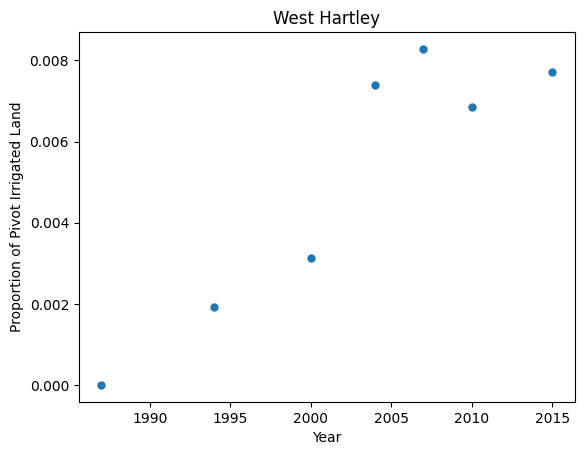

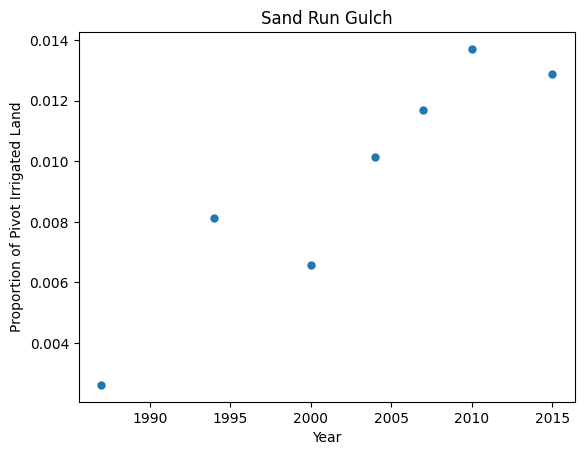

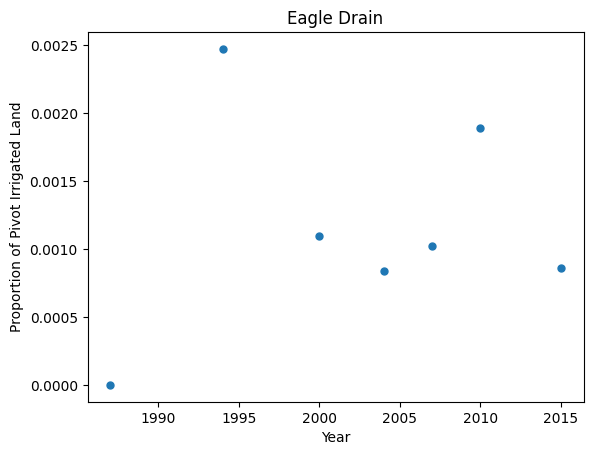

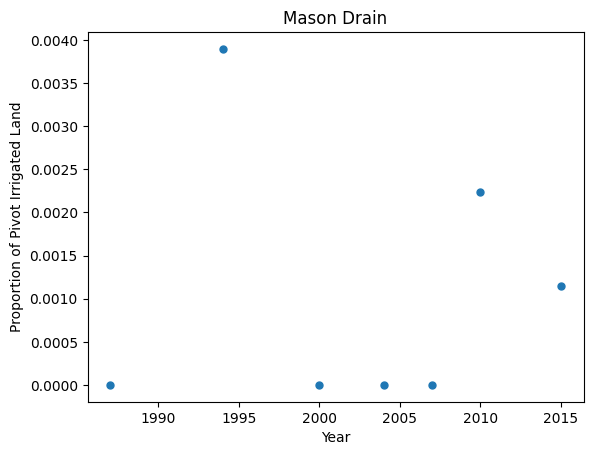

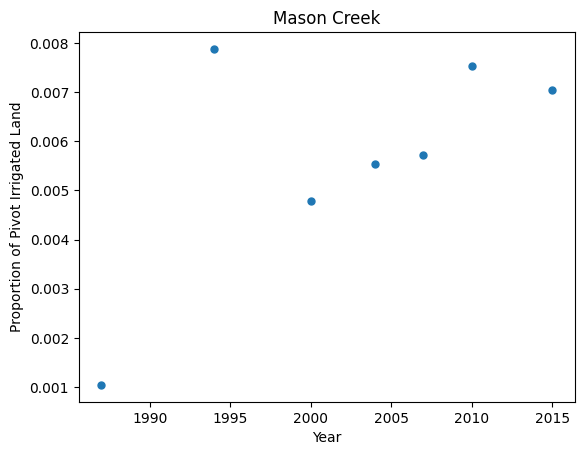

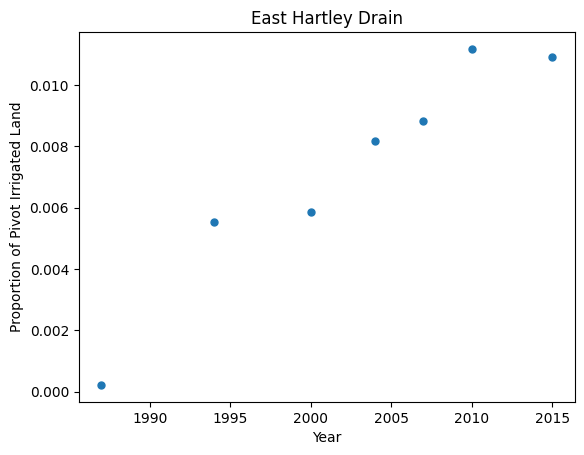

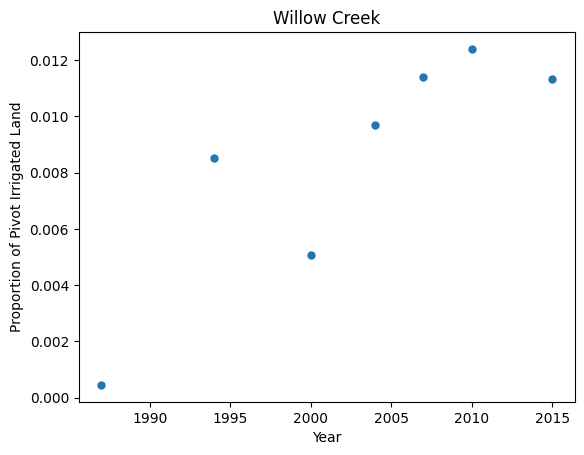

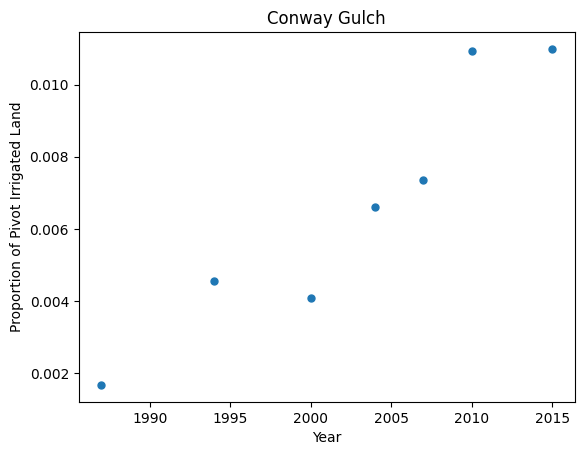

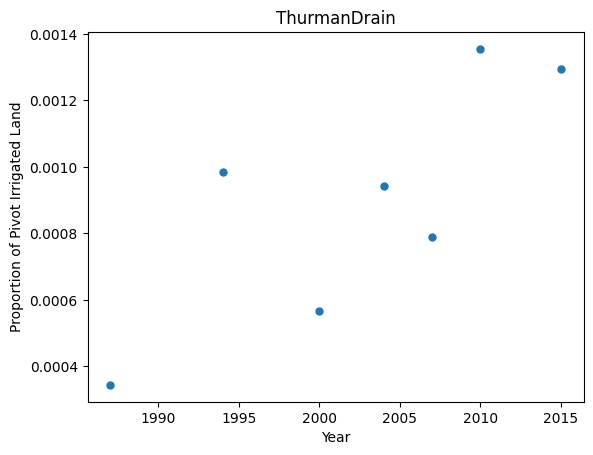

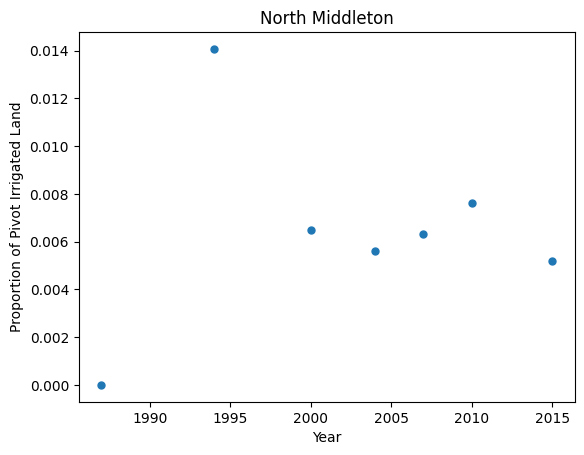

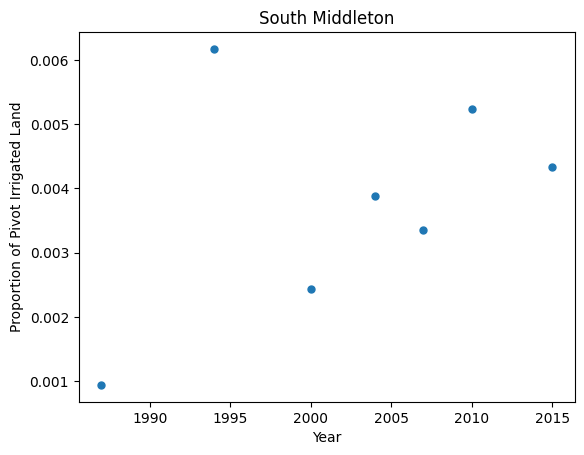

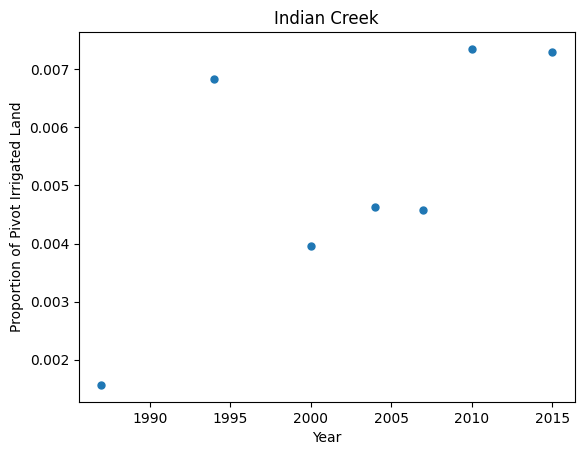

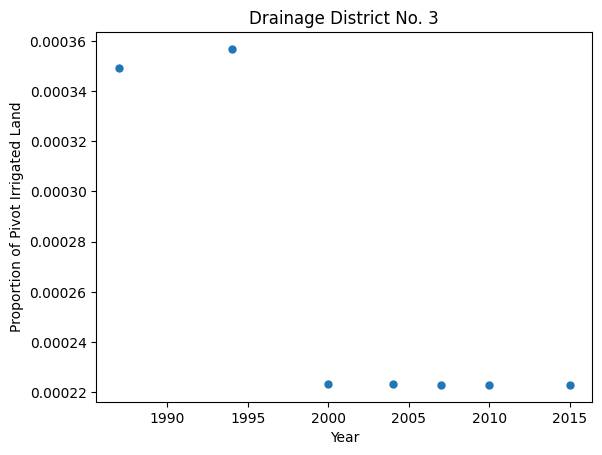

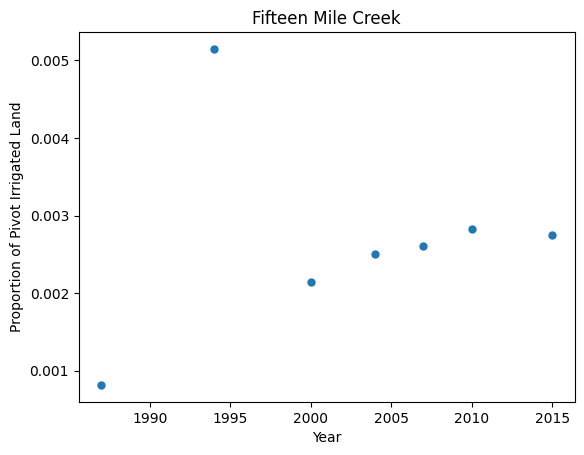

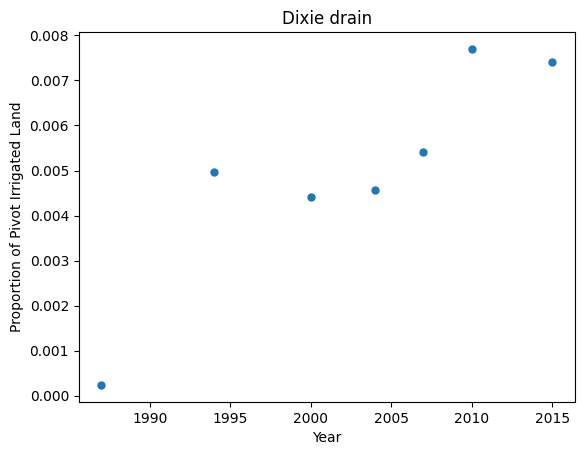

In [ ]:
# -------------------------- #
#  Plot for each Drainshed   #
# -------------------------- #

names = df['Name'].unique()
grouped = df.groupby('Name')

# Iterate over each unique name
for i in names:
    temp_df = grouped.get_group(i)

    # Extract the year and proportion for plotting
    year = temp_df['Year']
    prop = temp_df['Pivot Proportion']

    plt.plot(year, prop, 'o', markersize=5)
    plt.title(f"{i}")
    plt.xlabel('Year')
    plt.ylabel('Proportion of Pivot Irrigated Land')
    plt.show()

In [ ]:
# -------------------------- #
#  Plot for ALL Drainsheds   #
# -------------------------- #

df = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigation_change.csv')

grouped = df.groupby('Name')
year = df['Year']

fig = go.Figure()

# Loop through the grouped data
for year, data in grouped:
    fig.add_trace(go.Scatter(
        x=data['Year'],
        y=data['Pivot Proportion'],
        mode='lines',
        name=str(year)
    ))

fig.update_layout(
    title="Irrigation Change in the Treasure Valley",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Pivot Proportion')
)

fig.show()

In [5]:
# ------------------------------------------- #
#  Linear Regresion plot for each Drainshed   #
# ------------------------------------------- #

grouped = df.groupby('Name')

output_dir = '/content/drive/MyDrive/Data/Model Modifications/irrigation_change/Figures/drainshed_regressions/linear/'
os.makedirs(output_dir, exist_ok=True)

for name, group in grouped:
    # Fit the linear regression model for each group
    model = LinearRegression()
    X = group[['Year']]
    y = group['Pivot Proportion']
    model.fit(X, y)

    # Predict values using the fitted model
    group['Predicted_Acres'] = model.predict(X)

    # Calculate the R² value
    r_squared = model.score(X, y)

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=group, x='Year', y='Pivot Proportion', marker='o', label='Actual Data')
    plt.plot(group['Year'], group['Predicted_Acres'], color='red', label='Regression Line')
    plt.title(f'Regression for {name}')
    plt.xlabel('Year')
    plt.ylabel('Proportion of Land Irrigated with Pivot')
    plt.grid(True)
    plt.legend()

    # Annotate the R² value on the plot
    plt.text(
        0.05, 0.85, f'R²: {r_squared:.2f}',
        transform=plt.gca().transAxes, fontsize=12, verticalalignment='top'
    )

    plot_filename = f'{name}_regression.tiff'
    plt.savefig(os.path.join(output_dir, plot_filename), format='tiff', dpi=300)
    plt.close()

In [ ]:
# ----------------------------------------------- #
#  Expoential Regresion plot for each Drainshed   #
# ----------------------------------------------- #

grouped = df.groupby('Name')

output_dir = '/content/drive/MyDrive/Data/Model Modifications/irrigation_change/Figures/drainshed_regressions/'
os.makedirs(output_dir, exist_ok=True)

for name, group in grouped:
    # Transform y to log(y) for exponential regression
    X = group[['Year']]
    y = np.log(group['Pivot Proportion'])

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict values using the fitted model (back-transform the log prediction)
    group['Predicted_Acres'] = np.exp(model.predict(X))

    # Calculate the R² value (on the original scale)
    y_actual = group['Pivot Irrigated Acres']
    y_pred = group['Predicted_Acres']
    r_squared = 1 - (np.sum((y_actual - y_pred) ** 2) / np.sum((y_actual - np.mean(y_actual)) ** 2))

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=group, x='Year', y='Pivot Irrigated Acres', marker='o', label='Actual Data')
    plt.plot(group['Year'], group['Predicted_Acres'], color='red', label='Exponential Regression Line')
    plt.title(f'Exponential Regression for {name}')
    plt.xlabel('Year')
    plt.ylabel('Land Irrigated with Pivot')
    plt.grid(True)
    plt.legend()

    # Annotate the R² value on the plot
    plt.text(
        0.05, 0.85, f'R²: {r_squared:.2f}',
        transform=plt.gca().transAxes, fontsize=12, verticalalignment='top'
    )

    plot_filename = f'{name}_exponential_regression.tiff'
    plt.savefig(os.path.join(output_dir, plot_filename), format='tiff', dpi=300)
    plt.close()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log



ValueError: Input y contains infinity or a value too large for dtype('float64').

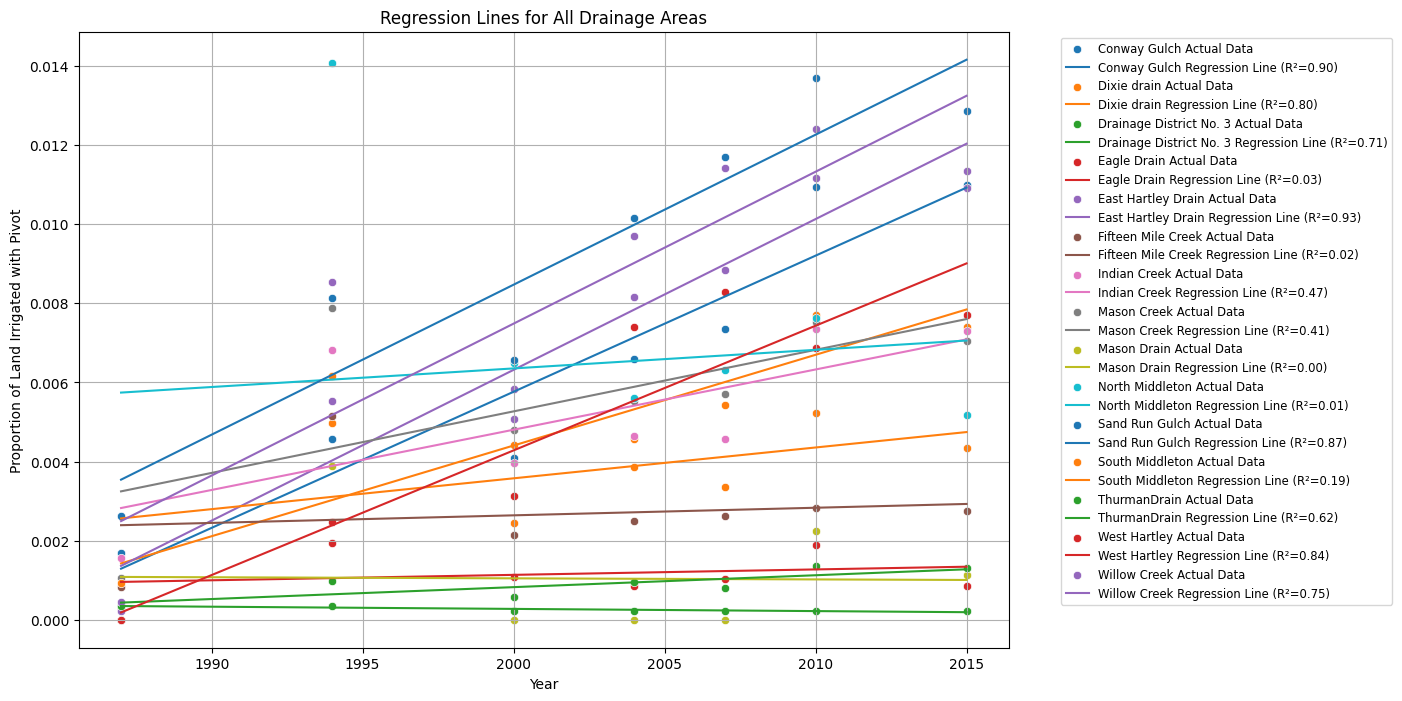

In [ ]:
# ---------------------------------------- #
#  Combined Figure of all Regresion Plots
# ---------------------------------------- #
df = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigation_change.csv')
grouped = df.groupby('Name')
plt.figure(figsize=(12, 8))

for name, group in grouped:
    model = LinearRegression()
    X = group[['Year']]
    y = group['Pivot Proportion']
    model.fit(X, y)
    group['Predicted_Acres'] = model.predict(X)

    r_squared = model.score(X, y) # Calculate the R² value
    sns.scatterplot(data=group, x='Year', y='Pivot Proportion', label=f'{name} Actual Data', marker='o')
    plt.plot(group['Year'], group['Predicted_Acres'], label=f'{name} Regression Line (R²={r_squared:.2f})')  # plot the regression line

plt.title('Regression Lines for All Drainage Areas')
plt.xlabel('Year')
plt.ylabel('Proportion of Land Irrigated with Pivot')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Adjust legend position

output_dir = '/content/drive/MyDrive/Data/Model Modifications/irrigation_change/Figures/drainshed_regressions/linear'
os.makedirs(output_dir, exist_ok=True)
combined_plot_filename = 'all_drainshed_regressions.tiff'
plt.savefig(os.path.join(output_dir, combined_plot_filename), format='tiff', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

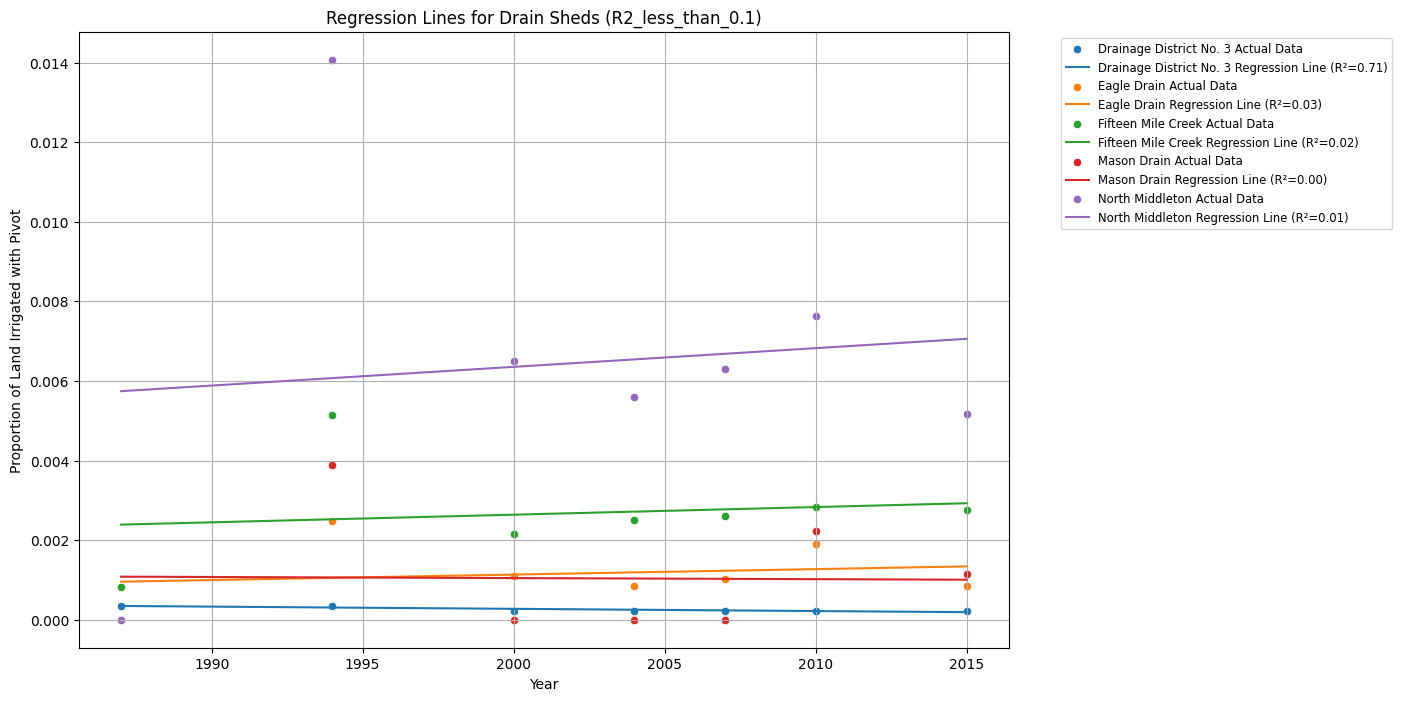

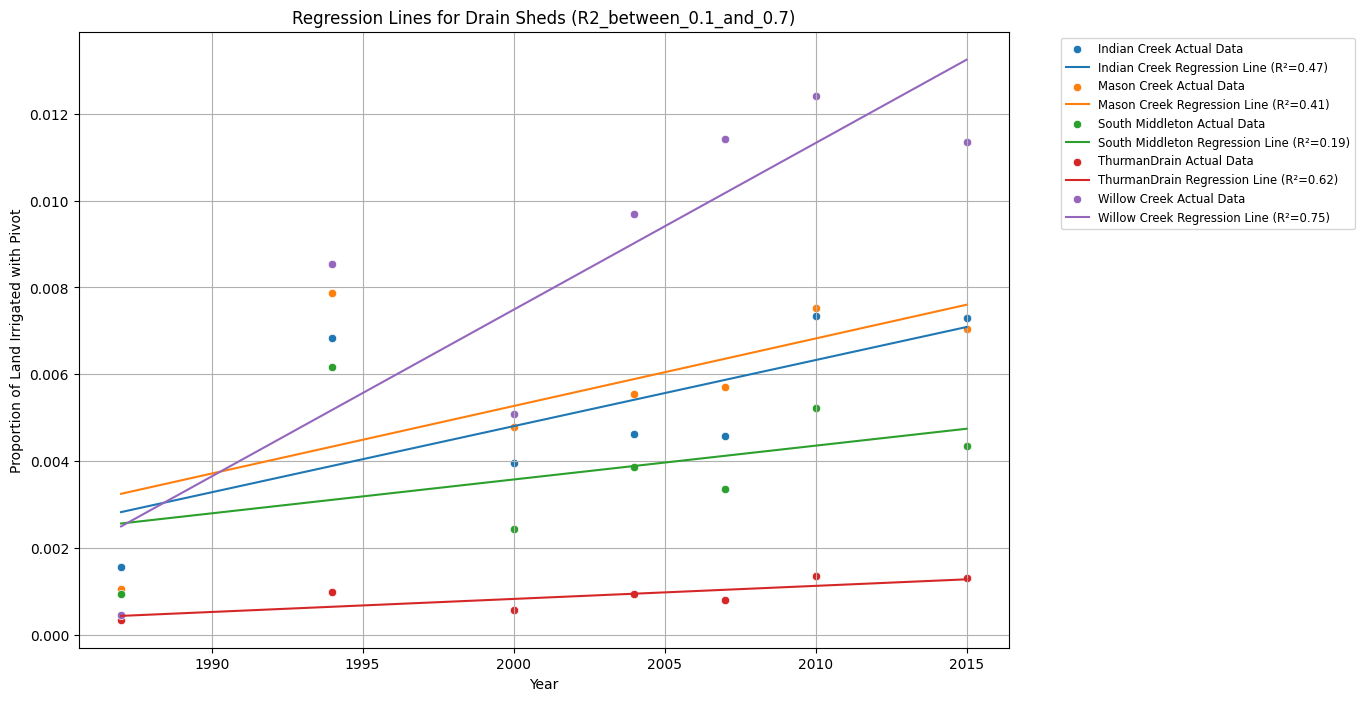

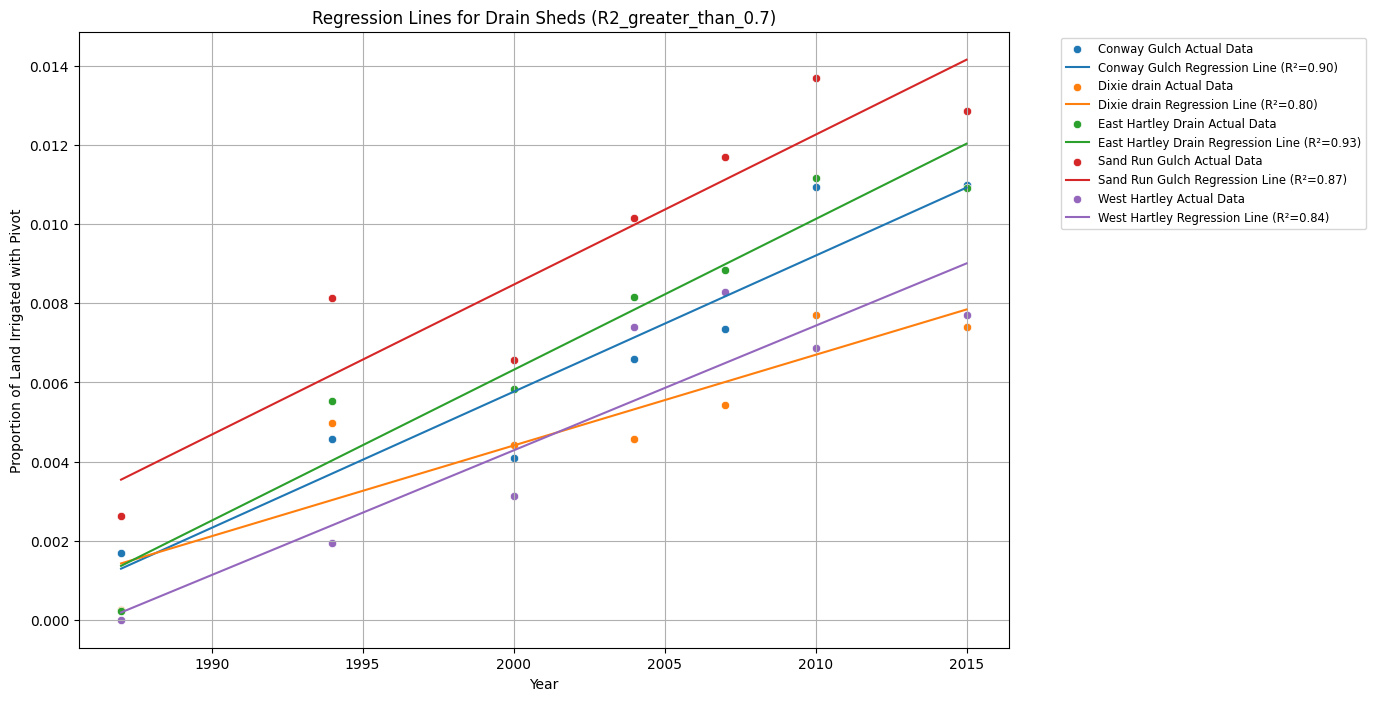

In [11]:
# ---------------------------------------- #
#         3 Linear Regression Plots
# ---------------------------------------- #

# based on r^2


df = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigation_change.csv')
grouped = df.groupby('Name')

low_r2 = []
mid_r2 = []
high_r2 = []

for name, group in grouped:
    model = LinearRegression()
    X = group[['Year']]
    y = group['Pivot Proportion']
    model.fit(X, y)
    group['Predicted_Acres'] = model.predict(X)

    # Calculate the R² value
    r_squared = model.score(X, y)

    # Categorize the groups based on R² value, force Drainage Distric No 3 into low_r2
    if name == "Drainage District No. 3" or r_squared < 0.1:
        low_r2.append((name, group, r_squared))
    elif 0.1 <= r_squared <= 0.76:
        mid_r2.append((name, group, r_squared))
    else:
        high_r2.append((name, group, r_squared))

# Function to plot and save the figures for each R² category
def plot_regressions(data, category, output_dir):
    plt.figure(figsize=(12, 8))
    for name, group, r_squared in data:
        sns.scatterplot(data=group, x='Year', y='Pivot Proportion', label=f'{name} Actual Data', marker='o')
        plt.plot(group['Year'], group['Predicted_Acres'], label=f'{name} Regression Line (R²={r_squared:.2f})')

    plt.title(f'Regression Lines for Drain Sheds ({category})')
    plt.xlabel('Year')
    plt.ylabel('Proportion of Land Irrigated with Pivot')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    os.makedirs(output_dir, exist_ok=True)
    plot_filename = f'drainshed_regressions_{category}.tiff'
    plt.savefig(os.path.join(output_dir, plot_filename), format='tiff', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

output_dir = '/content/drive/MyDrive/Data/Model Modifications/irrigation_change/Figures/drainshed_regressions/linear_grouped/'

plot_regressions(low_r2, 'R2_less_than_0.1', output_dir)
plot_regressions(mid_r2, 'R2_between_0.1_and_0.7', output_dir)
plot_regressions(high_r2, 'R2_greater_than_0.7', output_dir)

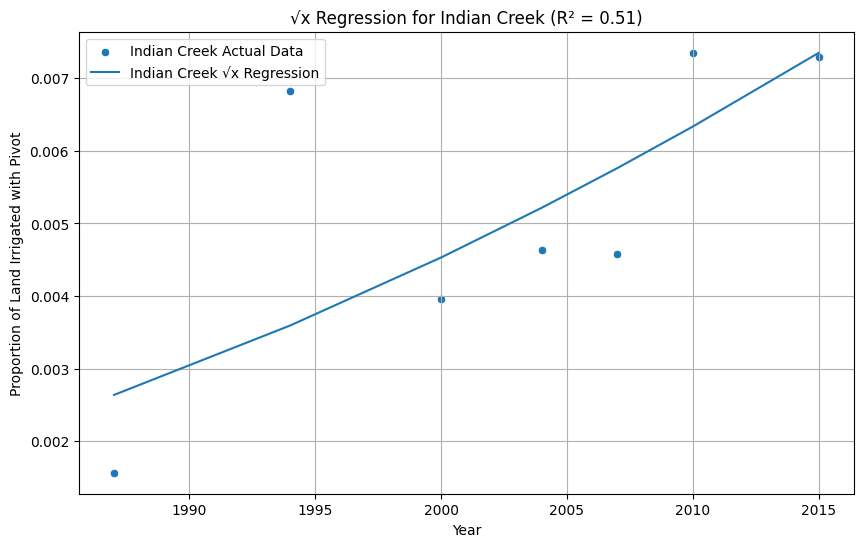

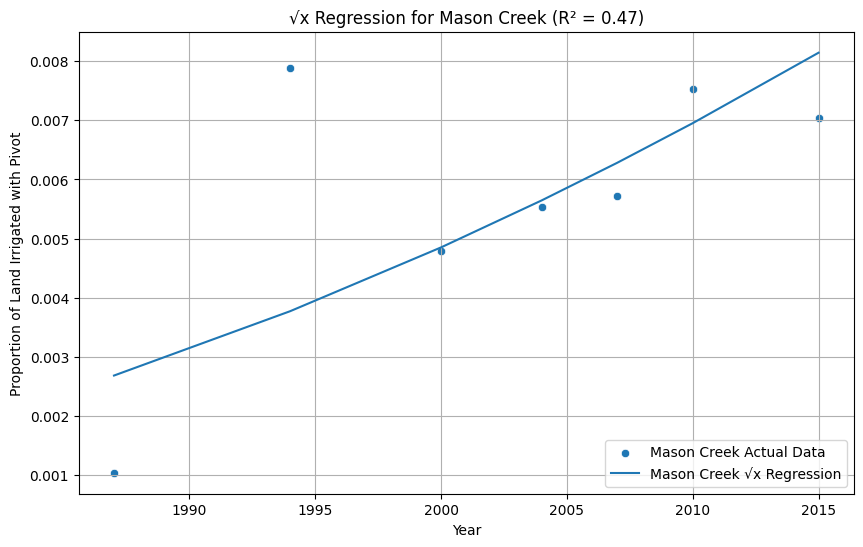

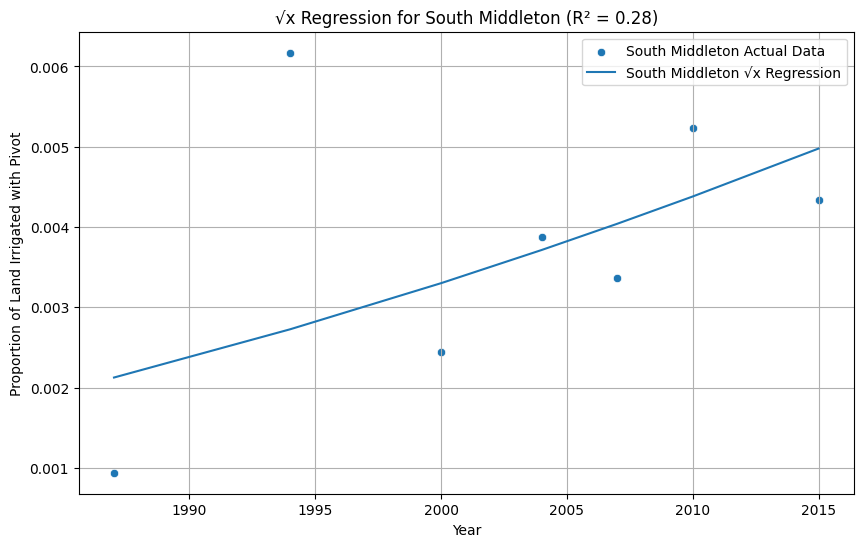

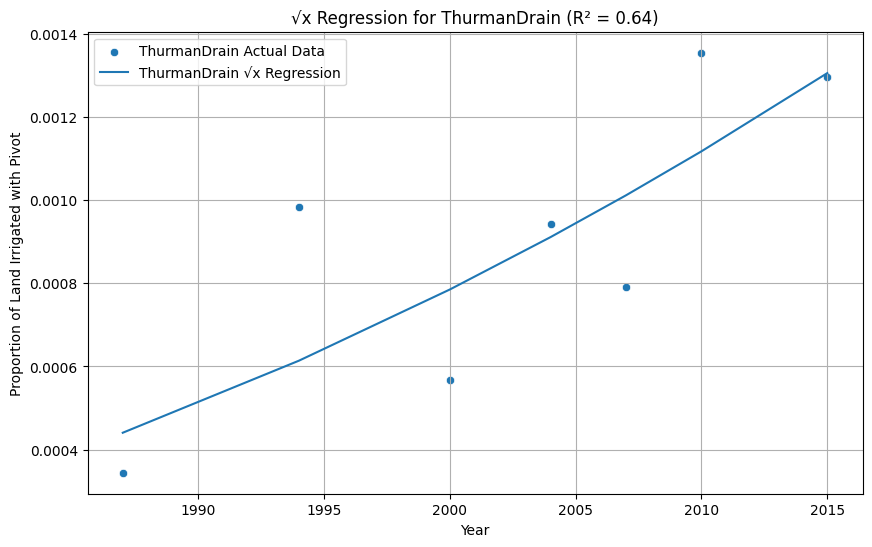

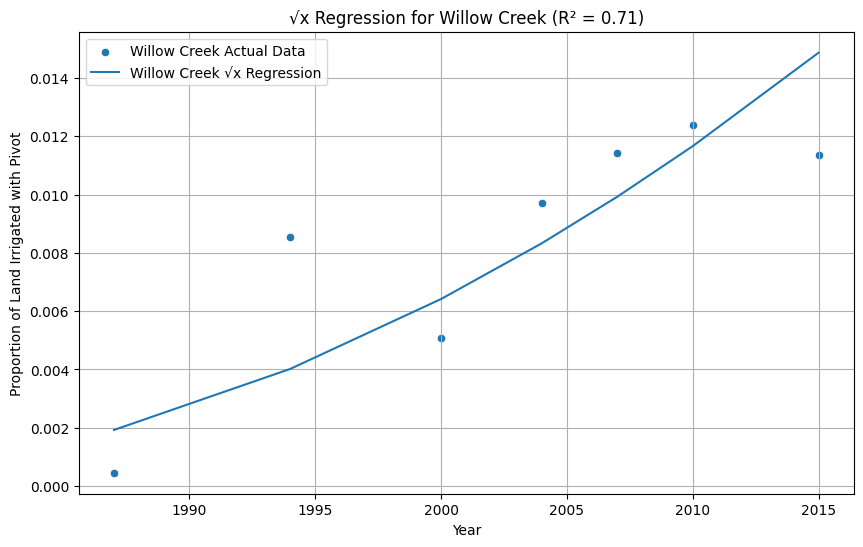

In [26]:
# ---------------------------------------- #
#    Exp Regression Plot for some drains
# ---------------------------------------- #


output_dir = '/content/drive/MyDrive/Data/Model Modifications/irrigation_change/Figures/drainshed_regressions/sqrt_x'
df = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigation_change.csv')

# Filter the data for the specified drainage areas
drainages = ['Indian Creek', 'Mason Creek', 'South Middleton', 'ThurmanDrain', 'Willow Creek']
df_filtered = df[df['Name'].isin(drainages)]
grouped = df_filtered.groupby('Name')

# Iterate over each group to fit the x^1/2 regression and plot
for name, group in grouped:
    # Drop rows where 'Pivot Proportion' is negative (we can take the square root of zero, but not negatives)
    group = group[group['Pivot Proportion'] >= 0]

    # Initialize the linear regression model for sqrt-transformed values
    model = LinearRegression()
    X = group[['Year']]

    # Apply the square root transformation
    y_sqrt = np.sqrt(group['Pivot Proportion'])  # Square root transformation
    model.fit(X, y_sqrt)

    # Calculate predicted sqrt values and convert back to the original scale by squaring the predictions
    group['Predicted_Acres_Sqrt'] = model.predict(X) ** 2

    # Calculate the R^2 value
    r_squared = model.score(X, y_sqrt)

    # Plot actual data points
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=group, x='Year', y='Pivot Proportion', label=f'{name} Actual Data', marker='o')

    # Plot the sqrt regression line
    plt.plot(group['Year'], group['Predicted_Acres_Sqrt'], label=f'{name} √x Regression')

    # Add the R^2 value to the title
    plt.title(f'√x Regression for {name} (R² = {r_squared:.2f})')
    plt.xlabel('Year')
    plt.ylabel('Proportion of Land Irrigated with Pivot')
    plt.grid(True)
    plt.legend()

    # Save the plot
    plot_filename = f'{name.replace(" ", "_").lower()}_sqrt.tiff'
    plt.savefig(os.path.join(output_dir, plot_filename), format='tiff', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## 5. Create dataframe from regression data for input into GLMM model

In [ ]:
# ----------------------------------------- #
#  Build Data off of Regression for Model   #
# ----------------------------------------- #

grouped = df.groupby('Name')

all_predictions = pd.DataFrame()

for name, group in grouped:
    # Initialize and fit the linear regression model for each group
    model = LinearRegression()
    X = group[['Year']]
    y = group['Pivot Proportion']
    model.fit(X, y)

    # Predict values for the years 1987 to 2022
    future_years = pd.DataFrame({'Year': np.arange(1987, 2023)})
    predicted_proportions = model.predict(future_years)

    # Create a DataFrame for the predictions
    predictions_df = pd.DataFrame({
        'Year': future_years['Year'],
        'Name': name,
        'Predicted_Proportion': predicted_proportions
    })

    # Append the predictions to the overall DataFrame
    all_predictions = pd.concat([all_predictions, predictions_df], ignore_index=True)

all_predictions.to_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/irrigation_model_input.csv', index=False)

In [ ]:
# --------------------------------- #
#  Rename Drains to Match Dataset   #
# --------------------------------- #
# inputted because old data set wasn't merging correctly with model input

file = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/irrigation_model_input.csv')

def rename_names_in_csv(input_csv_path, output_csv_path, name_mapping):
    """
    Rename names in the 'Name' column of a CSV file.

    Parameters:
    input_csv_path (str): Path to the input CSV file.
    output_csv_path (str): Path to save the modified CSV file.
    name_mapping (dict): Dictionary where keys are old names and values are new names.

    """
    df = pd.read_csv(input_csv_path)
    if 'Name' not in df.columns:
        raise ValueError("The CSV file does not contain a 'Name' column.")
    df['Name'] = df['Name'].replace(name_mapping)
    df.to_csv(output_csv_path, index=False)
    print(f"CSV file with updated names saved to {output_csv_path}")

if __name__ == "__main__":
    input_csv = '/content/drive/MyDrive/Data/Model Modifications/irrigation_change/irrigation_model_input.csv'
    output_csv = '/content/drive/MyDrive/Data/Model Modifications/irrigation_change/irrigation_model_input.csv'

    # Dictionary with old names as keys and new names as values
    name_changes = {
        'Dixie drain': 'Dixie Drain',
        'Drainage District No. 3': 'Drainage District No3',
        'West Hartley': 'West Hartley Gulch',
        'East Hartley Drain': 'East Hartley Gulch'
    }

    rename_names_in_csv(input_csv, output_csv, name_changes)

CSV file with updated names saved to /content/drive/MyDrive/Data/Model Modifications/irrigation_change/irrigation_model_input.csv


## 6. Figure of Irrigation Types in the TV (from HDR 2022 data)

In [ ]:
# ------------------------ #
#   Import Libraries       #
# ------------------------ #

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import numpy as np

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -------------------- #
#     Import File      #
# -------------------- #

gdf =gpd.read_file('/content/drive/MyDrive/Data/irrigation_shapefiles/irrigated_land_only/2022_irrigated.shp')
gdf.columns

Index(['Name', 'Watershed', 'Acres', 'MelissaHUC', 'BJ_Com_Tie', '_2016_TU_S',
       'Classifica', 'SubSegment', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

Combined Surface Irrigated     0.695532
Combined Pressure Irrigated    0.304468
dtype: float64


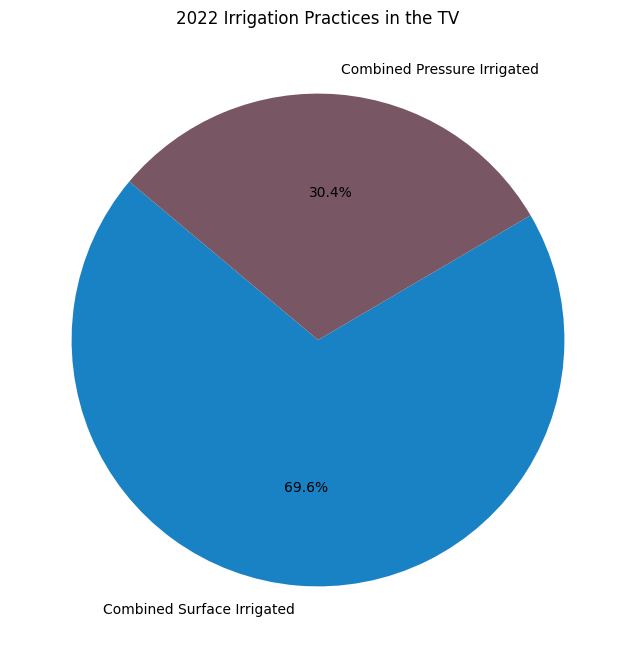

In [ ]:
# ------------------------------------- #
#     Pie Chart of Irrigation Type      #
# ------------------------------------- #

# Remove the 'Developed' category
irrigation_type_areas_filtered = irrigation_type_areas.drop('Developed')

# Combine 'Surface Irrigated (unchanged since 2003)' and 'New Surface Irrigated Field'
combined_surface_irrigated = (
    irrigation_type_areas_filtered['Surface Irrigated (unchanged since 2003)'] +
    irrigation_type_areas_filtered['New Surface Irrigated Field']
)

# Combine 'Pressure Irrigated (unchanged since 2003)' and 'New Pressure Irrigated Field'
combined_pressure_irrigated = (
    irrigation_type_areas_filtered['Pressure Irrigated (unchanged since 2003)'] +
    irrigation_type_areas_filtered['New Pressure Irrigated Field']
)

# Create a new Series for the combined categories
irrigation_type_areas_combined = pd.Series({
    'Combined Surface Irrigated': combined_surface_irrigated,
    'Combined Pressure Irrigated': combined_pressure_irrigated
})

# Recalculate the total area after combining
total_area_combined = irrigation_type_areas_combined.sum()

# Recalculate the proportions
irrigation_type_proportions_combined = irrigation_type_areas_combined / total_area_combined

print(irrigation_type_proportions_combined)

# Define a dictionary mapping each combined category to a specific color
color_map = {
    'Combined Surface Irrigated': '#1982C4',
    'Combined Pressure Irrigated': '#795663'
}

# Generate the list of colors in the order of the desired order
colors = [color_map[classification] for classification in irrigation_type_proportions_combined.index]

plt.figure(figsize=(8, 8))
irrigation_type_proportions_combined.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.ylabel('')  # Remove y-label for better aesthetics
plt.title('2022 Irrigation Practices in the TV')
plt.show()

Classifica
New Pressure Irrigated Field                 0.127764
New Surface Irrigated Field                  0.032043
Pressure Irrigated (unchanged since 2003)    0.176704
Surface Irrigated (unchanged since 2003)     0.663489
Name: Acres, dtype: float64
Classifica
Surface Irrigated (unchanged since 2003)     0.663489
Pressure Irrigated (unchanged since 2003)    0.176704
New Pressure Irrigated Field                 0.127764
New Surface Irrigated Field                  0.032043
Name: Acres, dtype: float64


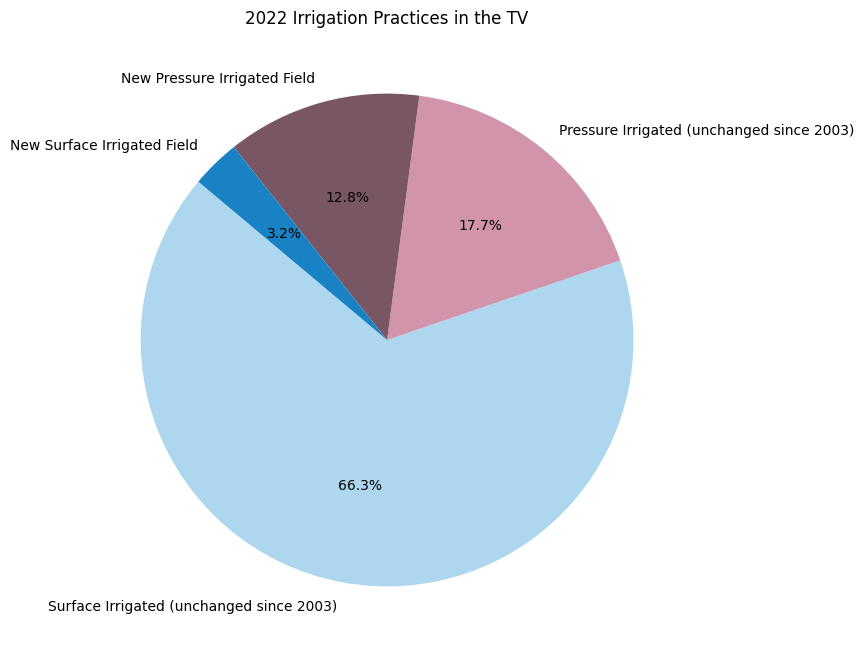

In [ ]:
# Remove the 'Developed' category
irrigation_type_areas_filtered = irrigation_type_areas.drop('Developed')

# Recalculate the total area excluding 'Developed'
total_area_filtered = irrigation_type_areas_filtered.sum()

# Recalculate the proportions
irrigation_type_proportions_filtered = irrigation_type_areas_filtered / total_area_filtered

print(irrigation_type_proportions_filtered)

# Define the desired order of the categories
desired_order = [
    'Surface Irrigated (unchanged since 2003)',
    'Pressure Irrigated (unchanged since 2003)',
    'New Pressure Irrigated Field',
    'New Surface Irrigated Field'
]

# Reorder the Series according to the desired order
irrigation_type_proportions_reordered = irrigation_type_proportions_filtered.reindex(desired_order)

print(irrigation_type_proportions_reordered)

# Define a dictionary mapping each classification to a specific color
color_map = {
    'New Pressure Irrigated Field': '#795663',
    'New Surface Irrigated Field': '#1982C4',
    'Pressure Irrigated (unchanged since 2003)': '#D294AB',
    'Surface Irrigated (unchanged since 2003)': '#ADD6EF'
}

# Generate the list of colors in the order of the desired order
colors = [color_map[classification] for classification in desired_order]

plt.figure(figsize=(8, 8))
irrigation_type_proportions_reordered.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=colors)
plt.ylabel('')  # Remove y-label for better aesthetics
plt.title('2022 Irrigation Practices in the TV')
plt.show()